# Who voted what? - A dive into the Colombia's peace plebiscite outcome

**_by Gabriel Vizcaino Sanchez_**

Last October 2th was a milestone in the Colombian history. On that Sunday, Colombians casted votes approving or rejecting the peace agreement signed between the official government and FARC guerrilla. The outcome came as a setback to pollsters’ predictions as the negative vote prevailed by a razor-thin margin of 50.21% to 49.78%, leaving the country immersed in a massive sea of uncertainty. This plebiscite was important since the peace accord represents an opportunity to halt an armed conflict prolonged for over 50 years, which so far has left the an estimated of 218,000 people killed, 27,000 kidnappings, 5.7 million forced displaces and many more human rights violations and war crimes (see plot below).

In this tutorial, the results from the plebiscite are collected, processed and analyzed.  Theis dataset is crossed with adjacent country statistics (e.g. poverty rate and conflict impact region-wise), to answer insightful questions and draw conclusions using data analytics techniques. 

[<img src="1402confl.png" width="600">](https://www.wola.org/files/images/1402confl.png)

The tutorial is organized as follows:
- [Background](#Background)
- [Setting up the data](#Setting-up-the-data)
- [How did "YES/"NO" votes distribute?](#How-did-"YES/"NO"-votes-distribute?)
- [What did the most vulnerable regions vote?](#What-did-the-most-vulnerable-regions-vote?)
- [Did people actually vote?](#Did-people-actually-vote?)
- [Main takeaways](#Main-takeaways)
- [References](#References)

## Background

FARC is the oldest and largest a guerrilla in Latin America. This leftist group is known for employing a variety of military tactics including terrorism, children recruitment and sexual assault, among other unconventional methods.  Colombian governments have combatted this group along history in order to protect the population and civil infrastructure. Not surprisingly, the poorest regions of the country have suffered the most the fallouts from this conflict. 

Attempts to negotiate with FARC have been undertaken in the past with unsuccessful results. On August 2012, the government of President Juan Manual Santos embarked in a new negotiation with FARC seeking to terminate this conflict once and for all. After four years of negations both parties crafted an agreement, the first ever reached, which renders a true possibility to end this half-century-long warfare.  

To boost public support and preserve legitimacy, President Santos promised to give people the opportunity to back or reject the accord through this plebiscite. Voters were asked a single question in the ballot:

_**“Do you support the final accord to end the conflict and build a stable and lasting peace?”**_

The possible answers were: **“YES”** or **“NO”**. _Any other answers would make the vote invalid_. For further information about the conflict and peace agreement in Colombia, please refer to the links in [References](#References).

## Setting up the data

A web scraper was programmed to extract the data since results from the plebiscite are available in the form of infrographics at the [Colombia's National Registry website](http://plebiscito.registraduria.gov.co/99PL/DPLZZZZZZZZZZZZZZZZZ_L1.htm). The country is divided in 32 regions plus the Capital District. Here, the consulates are treated as a region, then totaling 34 regions. Furthermore, regions are divided into cities and municipalities - for the sake of simplicity,  _municipality_ will refer to both categories. There are 1,098 municipalities in the database.

The following python libraries are used in this tutorial:

In [3]:
import numpy as np, math, requests, re, pandas as pd, json, geopandas as gpd
import matplotlib, shapely, rtree, matplotlib.pyplot as plt, seaborn as sns
from bs4 import BeautifulSoup
from scipy.stats import norm
from geopy.geocoders import GoogleV3
%matplotlib inline
matplotlib.rc("figure", figsize=(8,6));matplotlib.rc("axes", labelsize=16, titlesize=16)
matplotlib.rc("xtick", labelsize=14);matplotlib.rc("ytick", labelsize=14)
matplotlib.rc("legend", fontsize=14);matplotlib.rc("font", size=14);sns.set() 

Regional and municipal results are in different `url` addresses with an standardized HTML format. The `read_data_page` function parses the HTML content to extract the desired information using `BeautifulSoup and regular expressions`. This function returns a dictionary:
```python
{
    'total_voters': (int) Total eligible voters
    'voters': (int) Total actual votes
    'yes_votes': (int) Number of YES votes
    'yes_votes_p': (float) Proportion of YES votes
    'no_votes': (int) Number of NO votes
    'no_votes_p': (float) Proportion of NO votes
    'valid_votes': (int) Total valid votes
    'unmarked_votes': (int) Votes not marked
    'null_votes': (int) Null votes
}
```

In [3]:
def read_data_page(url):
    # This function reads the content of number of votes, type of votes, number of voters, etc... 
    
    output = {} # Dictionary containing the retrieved data
    raw = requests.get(url)
    pinput = BeautifulSoup(raw.content, "html.parser")
    
    # List of municipalities as xml tags
    try:
        muni_list = pinput.find('select', id = 'combo3').find_all('option')
    except AttributeError:
        muni_list = []
    
    # Number of voters vs. number of people allowed to vote 
    total_voters = pinput.find('div', class_ = 'cajaSupSegundaContainer').find('span', class_ = 'descripcionCaja').get_text()
    total_voters = total_voters.replace('.','')
    nums = re.compile(r"\d+").findall(total_voters)
    
    output['voters'] = int(nums[0])
    output['total_voters'] = int(nums[1])
    
    #Positive and negative votes
    votes = pinput.find_all('div', class_ = 'skill-bar-percent')
    temp = votes[0].get_text().replace('%','').replace(',','.')
    output['yes_votes_p'] = float(temp)/100
    temp = votes[1].get_text().replace('.','')
    output['yes_votes'] = int(re.compile(r"\d+").findall(temp)[0])
    temp = votes[2].get_text().replace('%','').replace(',','.')
    output['no_votes_p'] = float(temp)/100
    temp = votes[3].get_text().replace('.','')
    output['no_votes'] = int(re.compile(r"\d+").findall(temp)[0])
    
    #Valid and invalid votes
    temp = pinput.find('div', class_ = 'cajaInfPrimera').find('div', class_ = 'contenido').get_text().replace('.','')
    output['valid_votes'] = int(re.compile(r"\d+").findall(temp)[0])
    temp = pinput.find('div', class_ = 'cajaInfSegunda').find('div', class_ = 'contenido').get_text().replace('.','')
    output['unmarked_votes'] = int(re.compile(r"\d+").findall(temp)[0])    
    temp = pinput.find('div', class_ = 'cajaInfTercera').find('div', class_ = 'contenido').get_text().replace('.','')
    output['null_votes'] = int(re.compile(r"\d+").findall(temp)[0])    
    
    return output, muni_list

Two dictionaries of dictionaries are created: `regions` and `munis`, representing regions and municipalities respectively. The following script fills up the information in both dictionaries by iterating over the websites and calling the `read_data_page` function.

In [5]:
# Creating dictionies for regions and municipalities with name, url votes statistics for each one
# This script takes approximately 4.5 minutes
root_url = 'http://plebiscito.registraduria.gov.co'
url  = root_url + "/99PL/DPLZZZZZZZZZZZZZZZZZ_L1.htm"
rurl = requests.get(url)
pinput = BeautifulSoup(rurl.content, "html.parser")
reg_list = pinput.find('select', id = 'combo2').find_all('option') # List of regions as xml tags
regions = {}; munis = {}
for dpt in reg_list:
    reg_name = dpt.get_text().replace('.','').replace(',','')

    if reg_name == 'Todos':
        reg_name = 'COLOMBIA'
    
    reg_url = root_url + dpt['value'][2:]
    regions[reg_name] = {}
    regions[reg_name]['url'] = reg_url
    rdata = read_data_page(reg_url) # Extarcting data for the specific region
    regions[reg_name].update(rdata[0])
    
    if reg_name == 'COLOMBIA':
        continue
    
    # Creating dictionary for municipalities
    for muni in rdata[1]:
        muni_name = muni.get_text().replace('.','').replace(',','')

        if muni_name == 'Todos':
            continue
            
        munis[muni_name] = {}
        muni_url = root_url + muni['value'][2:]
        munis[muni_name]['region'] = reg_name
        munis[muni_name]['url'] = muni_url
        
        rdata2 = read_data_page(muni_url) # Extarcting data for the specific municipality
        munis[muni_name].update(rdata2[0])
    pass

An example of the dictionary structure for the municipality of SOACHA:
```python
region:  'CUNDINAMARCA'
url:  'http://plebiscito.registraduria.gov.co/99PL/DPL15247ZZZZZZZZZZZZ_L1.htm'
total_voters : 201745
voters : 90969
yes_votes : 42449
yes_votes_p : 0.4758
no_votes : 46767
no_votes_p:  0.5241
valid_votes:  89216
unmarked_votes:  289
null_votes:  1464```

The two dictionaries are then transformed into dataframes with rows listing the different regions/municipalities and columns correspond to the keys.

In [5]:
df_regions = pd.DataFrame.from_dict(regions, orient='index'); df_munis = pd.DataFrame.from_dict(munis, orient='index')
df_regions.drop('url', axis=1, inplace=True); df_regions.drop('COLOMBIA', inplace=True); 
df_munis.drop(df_munis[df_munis.no_votes == 0].index, axis=0, inplace=True)

Finally, additional data was incorporated to enhance the analysis. While a comprehensive assessment should consider a swath of socio-economic factors, given the scope of this tutorial and the availability of data, the present analysis only includes three additional factors:
- _Poverty:_ The latest estimations of economic poverty rate per region were downloaded from the National Statistics Department ([DANE](https://www.dane.gov.co/index.php/estadisticas-por-tema/pobreza-y-condiciones-de-vida/pobreza-y-desigualdad)) statistics database.
-  _Violence intensity index:_ This [map](http://www.kienyke.com/politica/las-zonas-de-mas-violencia-en-colombia) prepared by the Humanitarian Attention Unit (OCHA, acronym in Spanish), resumes the violent events occurred during 2012-2013 related to the armed conflict by region. A _violence index_ was computed by dividing the number of violent events into the total voters per region. These values were further normalized by setting the region with the highest score as “1” and then scaling the others accordingly. 
- _Vulnerability index:_ The [Foundation of Peace and Reconciliation]( http://www.pares.com.co/) has identified the municipalities most vulnerable to relapse into violence in a post-peace-agreement scenario given the historical strong presence of armed illegal groups. This [map]( http://www.las2orillas.co/wp-content/uploads/2015/02/mapa-.png) classifies the municipalities in four categories of vulnerability: _Low, Medium, High and Extreme_.

In [6]:
# Load and incorporate information in terms of poverty rate, income per capita and number of violent events per region
v_events = pd.read_csv(r'regional_data.csv',encoding='utf8'); v_events.set_index('Reg', inplace = 'True')
df_regions = df_regions.join(v_events)

# Load and incorporate information in terms conflict vulnerability index per municipality/city
vulner = pd.read_csv(r'vulnerability_index.csv',encoding='utf8'); vulner.set_index('muni', inplace = 'True');
df_munis = df_munis.join(vulner)

# Useful calculations
df_regions['yes_no_ratio'] = df_regions["yes_votes_p"]/df_regions["no_votes_p"]
df_munis['yes_no_ratio'] = df_munis["yes_votes_p"]/df_munis["no_votes_p"]
df_regions['elec_part'] = df_regions["voters"]/df_regions["total_voters"]
df_munis['elec_part'] = df_munis["voters"]/df_munis["total_voters"]
temp = (df_regions["v_events"]/df_regions["total_voters"]); temp = temp/max(temp);df_regions['conflict'] = temp;df_regions.tail(3)

,total_voters,null_votes,valid_votes,yes_votes,voters,unmarked_votes,no_votes_p,yes_votes_p,no_votes,v_events,poverty,income,yes_no_ratio,elec_part,conflict
VALLE,3401889,14529,1207566,633329,1228878,6783,0.4755,0.5244,574237,344,0.215,632636.0,1.102839,0.361234,0.054452
VAUPES,20898,41,4863,3796,4962,58,0.2194,0.7805,1067,3,0.278,590826.0,3.557429,0.237439,0.077303
VICHADA,47133,160,12116,6139,12371,95,0.4933,0.5066,5977,6,0.278,590826.0,1.026961,0.262470,0.068550


## How did "YES/"NO" votes distribute?
To get a sense upon how Colombians voted overall, Figures 1 and 2 show the histograms of "YES" and "NO" votes participation across municipalities, respectively. It is worth to highlight that the **"NO" votes won by a very tight margin of 24,213 votes (less than 0.2% of total votes)**. The histograms approximate to a triangular distribution in both categories, with mode around 55% for "NO" and 45% for "YES", although the average share of "YES" votes was higher. Interestingly, the standard deviation was the same in both cases, however, the coefficient of variation was higher for the "NO" meaning the it slightly variated more across the territory.

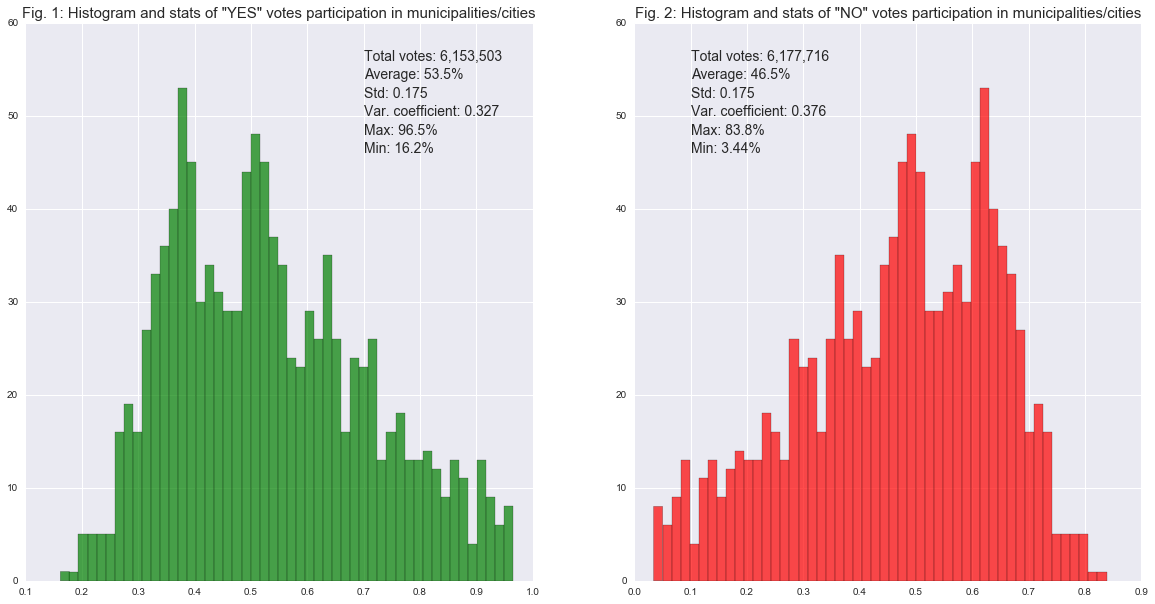

In [8]:
# Generations histograms and descriptive statistics of "Yes" and "No" votes
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
axes[0].hist(df_munis['yes_votes_p'],color='g',bins=50,alpha=0.7)
axes[0].text(0.7,56,r'Total votes: {:,}'.format(np.sum(df_munis['yes_votes'])),fontsize=14)
axes[0].text(0.7,54,r'Average: {0:.3g}%'.format(np.mean(df_munis['yes_votes_p'])*100),fontsize=14)
axes[0].text(0.7,52,r'Std: {0:.3g}'.format(np.std(df_munis['yes_votes_p'])),fontsize=14)
axes[0].text(0.7,50,r'Var. coefficient: {0:.3g}'.format(np.std(df_munis['yes_votes_p'])/np.mean(df_munis['yes_votes_p'])),fontsize=14)
axes[0].text(0.7,48,r'Max: {0:.3g}%'.format(np.max(df_munis['yes_votes_p'])*100),fontsize=14)
axes[0].text(0.7,46,r'Min: {0:.3g}%'.format(np.min(df_munis['yes_votes_p'])*100),fontsize=14)
axes[0].set_title('Fig. 1: Histogram and stats of "YES" votes participation in municipalities/cities',fontsize=15)
axes[1].hist(df_munis['no_votes_p'],color='r',bins=50,alpha=0.7);
axes[1].text(0.1,56,r'Total votes: {:,}'.format(np.sum(df_munis['no_votes'])),fontsize=14)
axes[1].text(0.1,54,r'Average: {0:.3g}%'.format(np.mean(df_munis['no_votes_p'])*100),fontsize=14)
axes[1].text(0.1,52,r'Std: {0:.3g}'.format(np.std(df_munis['no_votes_p'])),fontsize=14)
axes[1].text(0.1,50,r'Var. coefficient: {0:.3g}'.format(np.std(df_munis['no_votes_p'])/np.mean(df_munis['no_votes_p'])),fontsize=14)
axes[1].text(0.1,48,r'Max: {0:.3g}%'.format(np.max(df_munis['no_votes_p'])*100),fontsize=14)
axes[1].text(0.1,46,r'Min: {0:.3g}%'.format(np.min(df_munis['no_votes_p'])*100),fontsize=14)
axes[1].set_title('Fig. 2: Histogram and stats of "NO" votes participation in municipalities/cities',fontsize=15);

Data from Figures 1 and 2 show that even though on average Colombians voted favorably at the municipal level, the amount of "YES" votes gathered in pro-peace-agreement regions was not enough to outweigh the negative votes in the regions of opposition overall.

## What did the most vulnerable regions vote?
Considering that the armed conflict with FARC has spread geographically in an asymmetric fashion, there are zones largely more affected than others. Therefore, it is worthwhile to find out what is the stand of people directly impacted by this conflict with regards the peace agreement. A geospatial visualization comes handy in order to analyze variables that are geographically related. Using [`Geopandas`](http://geopandas.org/index.html) package and the [`geojson` map of Colombia](https://bl.ocks.org/john-guerra/43c7656821069d00dcbc), Figures 3 and 4 are generated to illustrate the ratio of YES/NO votes as well as the violence intensity index region-wise, respectively. 

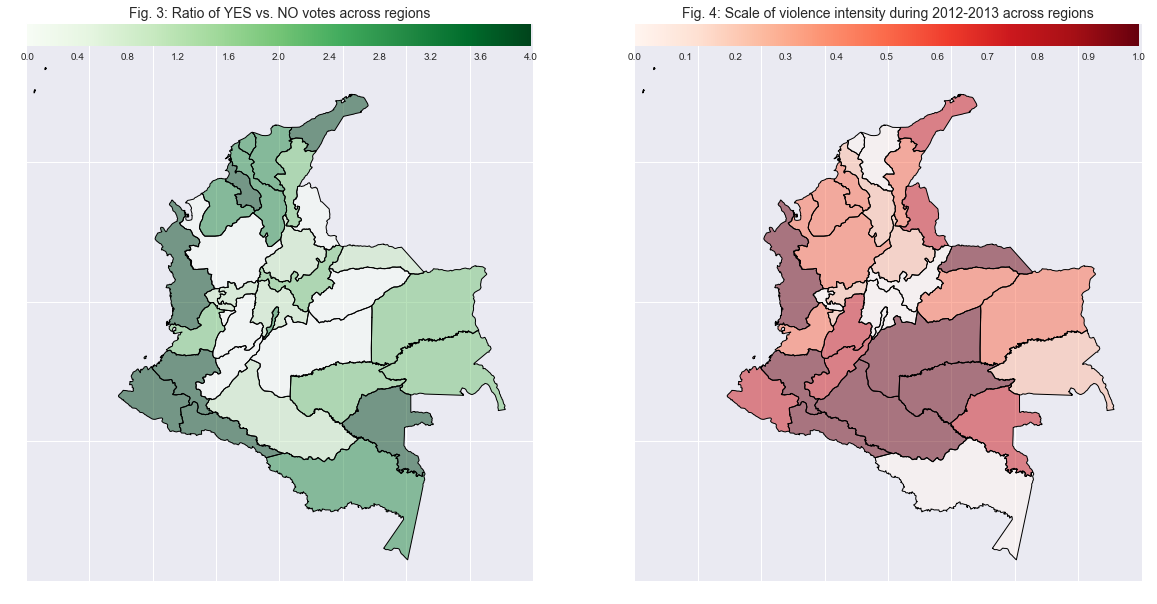

In [9]:
# Importing geojson file containing Colombian coordinates and merging data from df_regions
geo_regions = gpd.read_file('Colombia.geo.json.txt')
geo_regions.set_index('NOMBRE_DPT', inplace = True)
geo_regions = geo_regions.join(df_regions.loc[:,['yes_no_ratio','conflict']],how='inner')

# Map plot of YES/NO ratios and violence index across Colombia
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
ax1 = geo_regions.plot(column='yes_no_ratio', scheme='quantiles',figsize = (10,10),cmap='Greens',ax=axes[0]);
ax1.tick_params(axis='x', colors='white');ax1.tick_params(axis='y', colors='white')
ax1.set_title('Fig. 3: Ratio of YES vs. NO votes across regions',fontsize=14)
fig1 = ax1.get_figure();cax = fig1.add_axes([0.126, 0.868, 0.35, 0.03])
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=4, vmax=0)); sm._A = []
fig1.colorbar(sm, cax=cax, orientation='horizontal')
ax2 = geo_regions.plot(column='conflict', scheme='quantiles',figsize = (10,10),cmap='Reds',ax=axes[1]);
ax2.tick_params(axis='x', colors='white');ax2.tick_params(axis='y', colors='white')
ax2.set_title('Fig. 4: Scale of violence intensity during 2012-2013 across regions',fontsize=14)
fig2 = ax2.get_figure();cax = fig2.add_axes([0.548, 0.868, 0.35, 0.03])
sm2 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=1, vmax=0)); sm2._A = []
cb2 = fig2.colorbar(sm2, cax=cax, orientation='horizontal')

At the regional level, a modest positive correlation between the two variables plotted could be grasped by visually contrasting Figures 3 and 4. In regions like the West-coast and the South-west, where the intensity of violent events is high, "YES" votes outweighed "NO" votes by a factor of 2x to 4x. However, there also some regions highly affected by violence as well, like the Mid-south and Mid-north, where the "NO" votes prevailed. To dig deeper into this issue, the data could be also correlated with the vulnerability index at the municipal level. The following script generates Figure 5 which presents the average and standard deviation of “YES” and “NO” voting participation in municipalities classified by vulnerability category.    

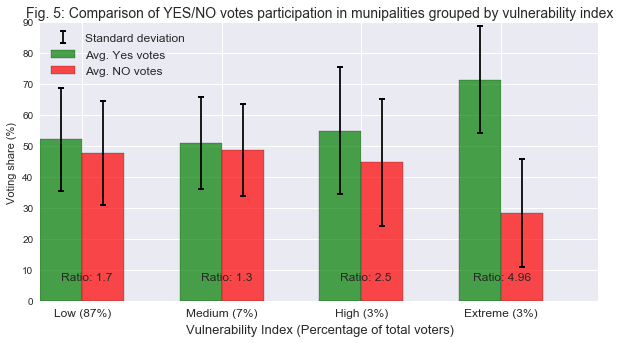

In [10]:
# Erorbar plot for YES/NO votes participation in munipalities grouped by vulnerability index
plt.figure(figsize=(10,5)); df_munis_gv = df_munis.groupby(['vulner_idx']);leng = np.arange(len(df_munis_gv)); wd = 0.3
yes_means = df_munis_gv['yes_votes_p'].mean()*100; yes_stds = df_munis_gv['yes_votes_p'].std()*100
no_means = df_munis_gv['no_votes_p'].mean()*100; no_stds = df_munis_gv['no_votes_p'].std()*100
plt.bar(leng,yes_means.values,wd,color='g',yerr=yes_stds.values,error_kw=dict(ecolor='black',capthick=2,label=''),alpha=0.7)
plt.bar(leng+wd,no_means.values,wd,color='r',yerr=no_stds.values, error_kw=dict(ecolor='black',capthick=2),alpha=0.7)
plt.ylabel('Voting share (%)');plt.xlabel('Vulnerability Index (Percentage of total voters)',fontsize = 13);
plt.legend(['Standard deviation','Avg. Yes votes','Avg. NO votes'],fontsize = 12,loc=2)
plt.title('Fig. 5: Comparison of YES/NO votes participation in munipalities grouped by vulnerability index',fontsize = 14)
vot = df_munis_gv['voters'].sum()/np.sum(df_munis['voters'])*100
plt.xticks(leng+wd); plt.xticks(leng+wd,('Low ({0:.2g}%)'.format(vot[0]), 'Medium ({0:.1g}%)'.format(vot[1]),'High ({0:.1g}%)'.format(vot[2]+1), 'Extreme ({0:.1g}%)'.format(vot[3])),fontsize = 12);
mm = df_munis_gv['yes_no_ratio'].mean(); 
plt.text(0.15,7,r'Ratio: {:,.2g}'.format(mm[0]));plt.text(1.15,7,r'Ratio: {:,.2g}'.format(mm[1]))
plt.text(2.15,7,r'Ratio: {:,.2g}'.format(mm[2]));plt.text(3.10,7,r'Ratio: {:,.3g}'.format(mm[3]));

Figure 5 conveys a conclusive message: **Colombians living in _High_ and _Extreme_ vulnerable municipalities across the country remarkably supported the peace agreement in the ballot**. This means that victims who unfortunately have suffered the most the stark consequences of this war (e.g. massacres, land displacement, child recruitment), are willing to back the government efforts to terminate the long-lasting armed conflict. However, the population in these zones only represents 6% of voters, therefore, people living in less vulnerable regions are the ones who actually made the final decision. While the average YES/NO ratio was also greater than one in Low and Medium vulnerable municipalities, negative votes casted primarily in the country’s center (i.e. urban areas) slightly surpassed the positive scenario portrayed specially in vulnerable zones (i.e. rural areas).

Furthermore, the YES/NO ratio is also correlated with data of poverty and electoral participation (i.e. voters/total_voters). Figure 6 and 7 illustrate this relation at the regional level for both variables respectively. **There is a positive correlation between the ratio of YES/NO votes and the poverty rate per region**. This result is coherent with the former claims, as people in least favorable regions from a socio-economic standpoint (e.g. rural areas or low income cities), were keener towards the agreement than people living in areas whit lower poverty rates. On the other hand, the YES/NO ratio also renders a negative correlation with the electoral participation, meaning that as votes grew in magnitude the negative share strengthened.

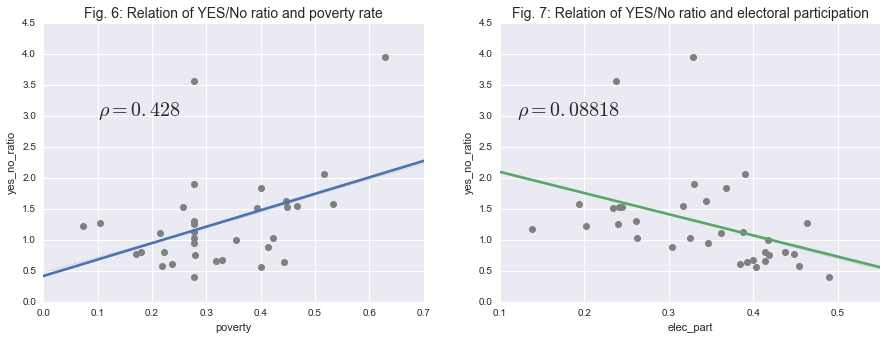

In [11]:
rho = df_regions.corr(method='pearson');fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax1=sns.regplot(x='poverty',y='yes_no_ratio',data=df_regions,ci=False,scatter_kws={"s": 50, "alpha": 1,'color':'grey'},ax=axes[0])
ax1.text(0.1,3,r'$\rho = {0:.3g}$'.format(rho['yes_no_ratio'][10]),fontsize=20);
ax1.set_title('Fig. 6: Relation of YES/No ratio and poverty rate',fontsize=14)
ax2=sns.regplot(x='elec_part',y='yes_no_ratio',data=df_regions,ci=False,scatter_kws={"s": 50, "alpha": 1,'color':'grey'},ax=axes[1])
ax2.text(0.12,3,r'$\rho = {0:.4g}$'.format(rho['yes_no_ratio'][14]),fontsize=20);
ax2.set_title('Fig. 7: Relation of YES/No ratio and electoral participation',fontsize=14);

## Did people actually vote?
Short answer: Not really!. Figure 8 shows the histogram of electoral participation at the municipal/city level. **Approximately 21 million voters didn’t show up to the ballot, representing 75% of the electoral population**. The maximum participation rate was 62% and the minimum 3%. To provide a reference, in the 2014 presidential elections the participation rate was about 40%. Several political analyst have associated this lackluster electoral participation with the low levels of popularity held by the current government. Another likely reason is the unfortunate effect of Hurricane Matthew in its journey near the North-cost during that weekend. 

To assess the likelihood of this meteorological event affecting the electoral participation rate, a dummy variable named `h_affect` is created to identify the regions and municipalities harmed by the pass of Hurricane Matthew.

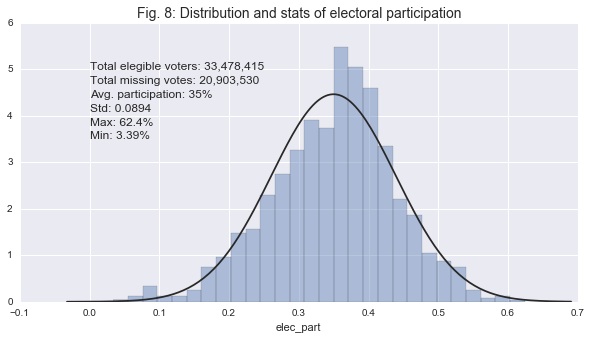

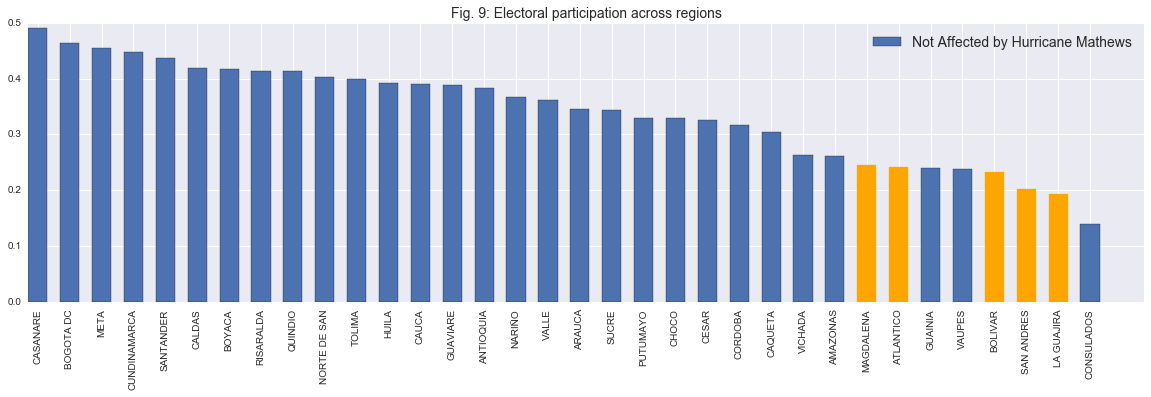

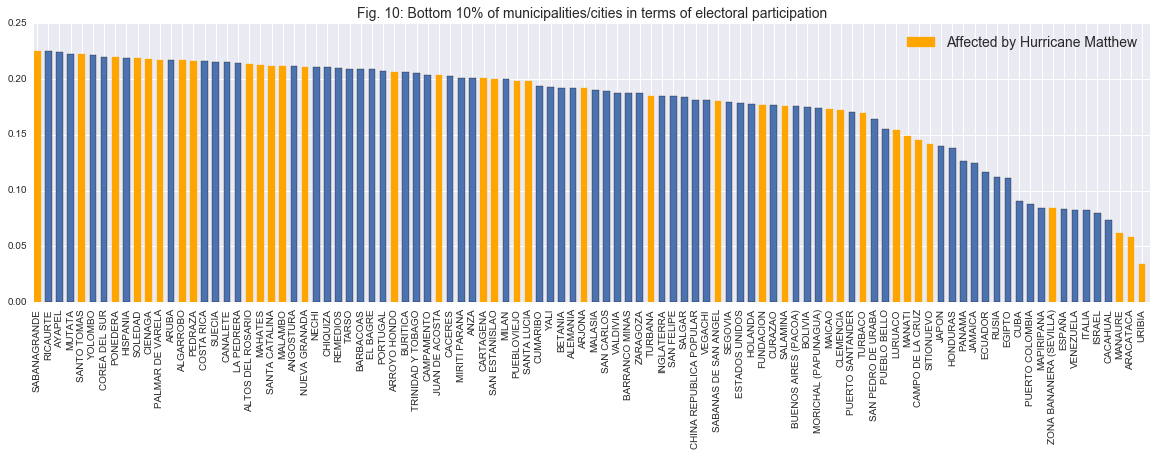

In [12]:
# Identifying regions affected by hurricane Mathews
dpts = ['ATLANTICO', 'LA GUAJIRA','SAN ANDRES','BOLIVAR', 'MAGDALENA']
df_regions['h_affect'] = [1 if i in dpts else 0 for i in df_regions.index]
df_munis['h_affect'] = [1 if i in dpts else 0 for i in df_munis['region']]

# Distribution of electoral participation
plt.figure(figsize=(10,5))
sns.distplot(df_munis["elec_part"],fit=norm, kde=False)
plt.title('Fig. 8: Distribution and stats of electoral participation', fontsize = 14)
plt.text(0.0001,5,r'Total elegible voters: {:,}'.format(np.sum(df_munis['total_voters'])))
plt.text(0.0001,4.7,r'Total missing votes: {:,}'.format(np.sum(df_munis['total_voters']-df_munis['voters'])))
plt.text(0.0001,4.4,r'Avg. participation: {0:.3g}%'.format(np.mean(df_munis['elec_part'])*100))
plt.text(0.0001,4.1,r'Std: {0:.3g}'.format(np.std(df_munis['elec_part'])))
plt.text(0.0001,3.8,r'Max: {0:.3g}%'.format(np.max(df_munis['elec_part'])*100))
plt.text(0.0001,3.5,r'Min: {0:.3g}%'.format(np.min(df_munis['elec_part'])*100))

# Plot electoral participation across regions
part = df_regions["elec_part"]; part = part.sort_values(ascending = False)
plt.figure(figsize=(20,5))
bar_plot1 = plt.bar(range(len(part)),part.values, 0.6); plt.xticks(np.arange(len(part))+0.3, part.index, rotation = 90);
[bar_plot1[i].set_color('orange') if v in dpts else '' for i,v in enumerate(part.index)];
plt.legend(['Not Affected by Hurricane Mathews', "Affected by Hurricane Matthew"], fontsize = 14);
plt.title('Fig. 9: Electoral participation across regions', fontsize = 14)

# Bottom 10% of municipalities/cities in terms of electoral participation
part = df_munis["elec_part"]; part = part.sort_values(ascending = False)[-100:]
plt.figure(figsize=(20,5))
bar_plot1 = plt.bar(range(len(part)),part.values, 0.6); plt.xticks(np.arange(len(part))+0.3, part.index, rotation = 90);
[bar_plot1[i].set_color('orange') if df_munis.loc[v,'h_affect'] == 1 else '' for i,v in enumerate(part.index)];
plt.title('Fig. 10: Bottom 10% of municipalities/cities in terms of electoral participation', fontsize = 14)
plt.legend(["Affected by Hurricane Matthew"], fontsize = 14);

Figures 9 shows the electoral participation rate at the regional level in a descending order. Orange colored bars correspond to the areas affected by the hurricane. Noticeably, four out of the eight regions with the lowest participation were coastal regions likely blocked-off because of the hurricane. At the municipal level, Figure 10 presents the bottom 10% of municipalities in terms of participation, and the impacted zones account for a big chunk as well. The average participation in this zones was _25%_ which contrats with the _35%_ national average. Moreover, the YES/NO ratio in those zones was _2.7x_ compared to _1.8x_ in the rest. **Therefore, given the slim difference between “YES” and “NO” votes, it could be argued that the Hurricane Mathew did have an effect in the electoral participation and such effect might in turn signified a tipping point in the final outcome of the plebiscite.**

Whatever the underlying reasons were for this drab participation rate, the fact is that it is rather disappointing and discouraging given the importance of what was at stake.

## Main takeaways
While a deeper study is required to further break-down these results, some conclusions can be drawn from the above analysis:
- Colombians rejected the peace agreement by a margin less than 0.2% of total votes. Even though on average the ratio of YES/NO votes was greater than one municipally-wise, positive votes weren't enough overall to outweigh negative votes.
- People living in _High_ and _Extreme_ vulnerable municipalities largely supported the peace agreement. Likewise, data shows a positive correlation between the YES/NO ratio and poverty rate region-wise.
- Electoral participation was very low with 75% of absence. 
- Data suggest that Hurricane Mathew did have a negative effect in this participation rate, and it might entailed a turning point in the plebiscite’s outcome given thin margin of difference.

As you read this tutorial, the Colombian government and FARC are sifting through the proposals submitted by opposition parties, seeking to incorporate them in a re-negotiated agreement. Colombians are eagerly awaiting for this process as a country loudly yelling that this conflict cannot be bore any longer.

## References
- (In spanish) http://lasillavacia.com/silla-blanca
- https://internationaljusticeathunter.wordpress.com/2012/03/18/brief-summary-of-armed-conflict-in-colombia-3/
- https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/01/sunday-colombians-vote-on-the-historic-peace-accord-with-the-farc-heres-what-you-need-to-know/
- https://www.wola.org/analysis/ending-50-years-of-conflict-in-colombia-a-new-report-from-wola/